# Molecular Descriptor Analysis for Drug Discovery

## Learning Objectives
By completing this tutorial, you will:
- Master molecular descriptor calculations using RDKit
- Apply Lipinski's Rule of Five and other drug-likeness criteria
- Calculate ADMET properties for pharmaceutical compounds
- Create professional visualizations for drug discovery
- Understand structure-property relationships in medicinal chemistry
- Build a molecular property prediction workflow

## Prerequisites
- Basic chemistry knowledge (molecular structure, functional groups)
- Python programming fundamentals
- Understanding of data analysis concepts

**Tools:** RDKit (industry-standard cheminformatics library)

## Introduction: Computational Drug Discovery

Drug discovery is a complex process that typically takes 10-15 years and costs over $1 billion per approved drug. Computational methods can significantly accelerate this process by:

1. **Virtual Screening**: Evaluating millions of compounds computationally
2. **Property Prediction**: Estimating ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity)
3. **Lead Optimization**: Improving drug candidates systematically

### Key Drug-Likeness Criteria

**Lipinski's Rule of Five** (Pfizer, 1997):
- Molecular weight ≤ 500 Da
- LogP ≤ 5
- Hydrogen bond donors ≤ 5
- Hydrogen bond acceptors ≤ 10

**Veber's Rule** (GSK, 2002):
- Rotatable bonds ≤ 10
- Polar surface area ≤ 140 Ų

In [3]:
# Import required libraries
import sys
import warnings
warnings.filterwarnings('ignore')

# Check for RDKit installation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Lipinski, Crippen, QED, rdMolDescriptors
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import IPythonConsole
    RDKIT_AVAILABLE = True
    print(" RDKit cheminformatics library loaded successfully")
except ImportError:
    RDKIT_AVAILABLE = False
    print("Note: RDKit not installed. Install with: conda install -c conda-forge rdkit")
    print("Proceeding with simulated molecular data...")

# Import data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed
np.random.seed(42)

print("\nMolecular Analysis Environment Ready")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
if RDKIT_AVAILABLE:
    from rdkit import rdBase
    print(f"RDKit version: {rdBase.rdkitVersion}")

✓ RDKit cheminformatics library loaded successfully



Molecular Analysis Environment Ready
NumPy version: 2.2.6
Pandas version: 2.3.1
RDKit version: 2025.03.3


## Part 1: Building a Pharmaceutical Compound Database

We'll analyze FDA-approved drugs and drug candidates using SMILES (Simplified Molecular Input Line Entry System) notation.

In [4]:
# Database of pharmaceutical compounds with therapeutic categories
drug_database = {
    # Analgesics/Anti-inflammatory
    'Aspirin': {
        'smiles': 'CC(=O)Oc1ccccc1C(=O)O',
        'category': 'Analgesic',
        'year_approved': 1897
    },
    'Paracetamol': {
        'smiles': 'CC(=O)Nc1ccc(O)cc1',
        'category': 'Analgesic',
        'year_approved': 1951
    },
    'Ibuprofen': {
        'smiles': 'CC(C)Cc1ccc(cc1)C(C)C(=O)O',
        'category': 'Anti-inflammatory',
        'year_approved': 1961
    },
    
    # Antibiotics
    'Penicillin G': {
        'smiles': 'CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O',
        'category': 'Antibiotic',
        'year_approved': 1942
    },
    'Amoxicillin': {
        'smiles': 'CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O',
        'category': 'Antibiotic',
        'year_approved': 1972
    },
    
    # Metabolic
    'Metformin': {
        'smiles': 'CN(C)C(=N)NC(=N)N',
        'category': 'Antidiabetic',
        'year_approved': 1957
    },
    'Atorvastatin': {
        'smiles': 'CC(C)c1c(C(=O)Nc2ccccc2)c(c(c3ccc(F)cc3)n1CCC(O)CC(O)CC(=O)O)c4ccccc4',
        'category': 'Statin',
        'year_approved': 1996
    },
    
    # Cardiovascular
    'Lisinopril': {
        'smiles': 'NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@H]1C(=O)O',
        'category': 'ACE Inhibitor',
        'year_approved': 1987
    },
    
    # Central Nervous System
    'Fluoxetine': {
        'smiles': 'CNCCC(Oc1ccc(cc1)C(F)(F)F)c2ccccc2',
        'category': 'Antidepressant',
        'year_approved': 1987
    },
    'Caffeine': {
        'smiles': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
        'category': 'Stimulant',
        'year_approved': 1820
    }
}

print(f"Pharmaceutical Database: {len(drug_database)} compounds")
print("\nTherapeutic Categories:")
categories = set(drug['category'] for drug in drug_database.values())
for cat in sorted(categories):
    count = sum(1 for d in drug_database.values() if d['category'] == cat)
    print(f"  • {cat}: {count} compounds")

Pharmaceutical Database: 10 compounds

Therapeutic Categories:
  • ACE Inhibitor: 1 compounds
  • Analgesic: 2 compounds
  • Anti-inflammatory: 1 compounds
  • Antibiotic: 2 compounds
  • Antidepressant: 1 compounds
  • Antidiabetic: 1 compounds
  • Statin: 1 compounds
  • Stimulant: 1 compounds


## Part 2: Molecular Descriptor Calculation

Molecular descriptors are numerical values that characterize chemical structures. They are fundamental for:
- QSAR (Quantitative Structure-Activity Relationships)
- Machine learning models
- Drug-likeness assessment

In [5]:
def calculate_molecular_descriptors(smiles, drug_name="Compound"):
    """
    Calculate comprehensive molecular descriptors for a compound.
    """
    if RDKIT_AVAILABLE:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Error: Invalid SMILES for {drug_name}")
            return None
        
        descriptors = {
            # Basic properties
            'MW': Descriptors.ExactMolWt(mol),
            'LogP': Crippen.MolLogP(mol),
            'LogD': Crippen.MolMR(mol),  # Molar refractivity as proxy
            
            # Lipinski descriptors
            'HBD': Lipinski.NumHDonors(mol),
            'HBA': Lipinski.NumHAcceptors(mol),
            
            # Veber descriptors
            'RotBonds': Lipinski.NumRotatableBonds(mol),
            'TPSA': Descriptors.TPSA(mol),
            
            # Additional descriptors
            'Rings': Lipinski.RingCount(mol),
            'AromaticRings': Lipinski.NumAromaticRings(mol),
            'HeavyAtoms': Lipinski.HeavyAtomCount(mol),
            'Complexity': rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
            
            # Drug-likeness scores
            'QED': QED.qed(mol)  # Quantitative Estimate of Drug-likeness
        }
    else:
        # Simulated descriptors for demonstration
        descriptors = {
            'MW': np.random.uniform(150, 600),
            'LogP': np.random.uniform(-1, 5),
            'LogD': np.random.uniform(20, 100),
            'HBD': np.random.randint(0, 6),
            'HBA': np.random.randint(1, 11),
            'RotBonds': np.random.randint(0, 11),
            'TPSA': np.random.uniform(20, 140),
            'Rings': np.random.randint(1, 5),
            'AromaticRings': np.random.randint(0, 3),
            'HeavyAtoms': np.random.randint(10, 40),
            'Complexity': np.random.randint(0, 5),
            'QED': np.random.uniform(0.3, 0.9)
        }
    
    return descriptors

# Example calculation for Aspirin
aspirin_descriptors = calculate_molecular_descriptors(
    drug_database['Aspirin']['smiles'], 
    'Aspirin'
)

if aspirin_descriptors:
    print("Molecular Descriptors for Aspirin:")
    print("="*40)
    for key, value in aspirin_descriptors.items():
        if isinstance(value, float):
            print(f"{key:15} {value:8.2f}")
        else:
            print(f"{key:15} {value:8d}")

Molecular Descriptors for Aspirin:
MW                180.04
LogP                1.31
LogD               44.71
HBD                    1
HBA                    3
RotBonds               2
TPSA               63.60
Rings                  1
AromaticRings          1
HeavyAtoms            13
Complexity             0
QED                 0.55


## Part 3: Drug-Likeness Assessment

We'll evaluate compounds against multiple drug-likeness criteria used by pharmaceutical companies.

In [6]:
def evaluate_drug_likeness(descriptors):
    """
    Evaluate a compound against multiple drug-likeness criteria.
    """
    results = {}
    
    # Lipinski's Rule of Five
    lipinski_violations = sum([
        descriptors['MW'] > 500,
        descriptors['LogP'] > 5,
        descriptors['HBD'] > 5,
        descriptors['HBA'] > 10
    ])
    results['Lipinski'] = {
        'violations': lipinski_violations,
        'pass': lipinski_violations <= 1
    }
    
    # Veber's Rule (Oral Bioavailability)
    veber_pass = (
        descriptors['RotBonds'] <= 10 and 
        descriptors['TPSA'] <= 140
    )
    results['Veber'] = {
        'pass': veber_pass
    }
    
    # Ghose Filter
    ghose_pass = (
        160 <= descriptors['MW'] <= 480 and
        -0.4 <= descriptors['LogP'] <= 5.6 and
        40 <= descriptors['LogD'] <= 130 and
        20 <= descriptors['HeavyAtoms'] <= 70
    )
    results['Ghose'] = {
        'pass': ghose_pass
    }
    
    # QED Score interpretation
    qed_score = descriptors['QED']
    if qed_score >= 0.67:
        qed_category = 'Excellent'
    elif qed_score >= 0.49:
        qed_category = 'Good'
    else:
        qed_category = 'Poor'
    
    results['QED'] = {
        'score': qed_score,
        'category': qed_category
    }
    
    return results

# Evaluate Aspirin
if aspirin_descriptors:
    aspirin_evaluation = evaluate_drug_likeness(aspirin_descriptors)
    
    print("\nDrug-Likeness Evaluation for Aspirin:")
    print("="*40)
    print(f"Lipinski's Rule: {'PASS' if aspirin_evaluation['Lipinski']['pass'] else 'FAIL'} "
          f"({aspirin_evaluation['Lipinski']['violations']} violations)")
    print(f"Veber's Rule: {'PASS' if aspirin_evaluation['Veber']['pass'] else 'FAIL'}")
    print(f"Ghose Filter: {'PASS' if aspirin_evaluation['Ghose']['pass'] else 'FAIL'}")
    print(f"QED Score: {aspirin_evaluation['QED']['score']:.3f} "
          f"({aspirin_evaluation['QED']['category']})")


Drug-Likeness Evaluation for Aspirin:
Lipinski's Rule: PASS (0 violations)
Veber's Rule: PASS
Ghose Filter: FAIL
QED Score: 0.550 (Good)


## Part 4: Complete Database Analysis

Now let's analyze all compounds in our pharmaceutical database.

In [7]:
# Analyze all drugs in the database
analysis_results = []

for drug_name, drug_info in drug_database.items():
    # Calculate descriptors
    descriptors = calculate_molecular_descriptors(drug_info['smiles'], drug_name)
    
    if descriptors:
        # Evaluate drug-likeness
        evaluation = evaluate_drug_likeness(descriptors)
        
        # Compile results
        result = {
            'Drug': drug_name,
            'Category': drug_info['category'],
            'Year': drug_info['year_approved'],
            **descriptors,
            'Lipinski_Pass': evaluation['Lipinski']['pass'],
            'Lipinski_Violations': evaluation['Lipinski']['violations'],
            'Veber_Pass': evaluation['Veber']['pass'],
            'Ghose_Pass': evaluation['Ghose']['pass'],
            'QED_Category': evaluation['QED']['category']
        }
        analysis_results.append(result)

# Create DataFrame
df_results = pd.DataFrame(analysis_results)

print(f"Analyzed {len(df_results)} pharmaceutical compounds")
print("\nDatabase Summary:")
print(df_results[['Drug', 'Category', 'MW', 'LogP', 'QED', 'Lipinski_Pass']].round(2))

Analyzed 10 pharmaceutical compounds

Database Summary:
           Drug           Category      MW  LogP   QED  Lipinski_Pass
0       Aspirin          Analgesic  180.04  1.31  0.55           True
1   Paracetamol          Analgesic  151.06  1.35  0.60           True
2     Ibuprofen  Anti-inflammatory  206.13  3.07  0.82           True
3  Penicillin G         Antibiotic  334.10  0.86  0.80           True
4   Amoxicillin         Antibiotic  365.10  0.02  0.55           True
5     Metformin       Antidiabetic  129.10 -1.03  0.25           True
6  Atorvastatin             Statin  558.25  6.31  0.16          False
7    Lisinopril      ACE Inhibitor  405.23  1.24  0.38           True
8    Fluoxetine     Antidepressant  309.13  4.44  0.85           True
9      Caffeine          Stimulant  194.08 -1.03  0.54           True


## Part 5: Visualization of Molecular Properties

Professional visualizations help identify patterns and outliers in molecular data.

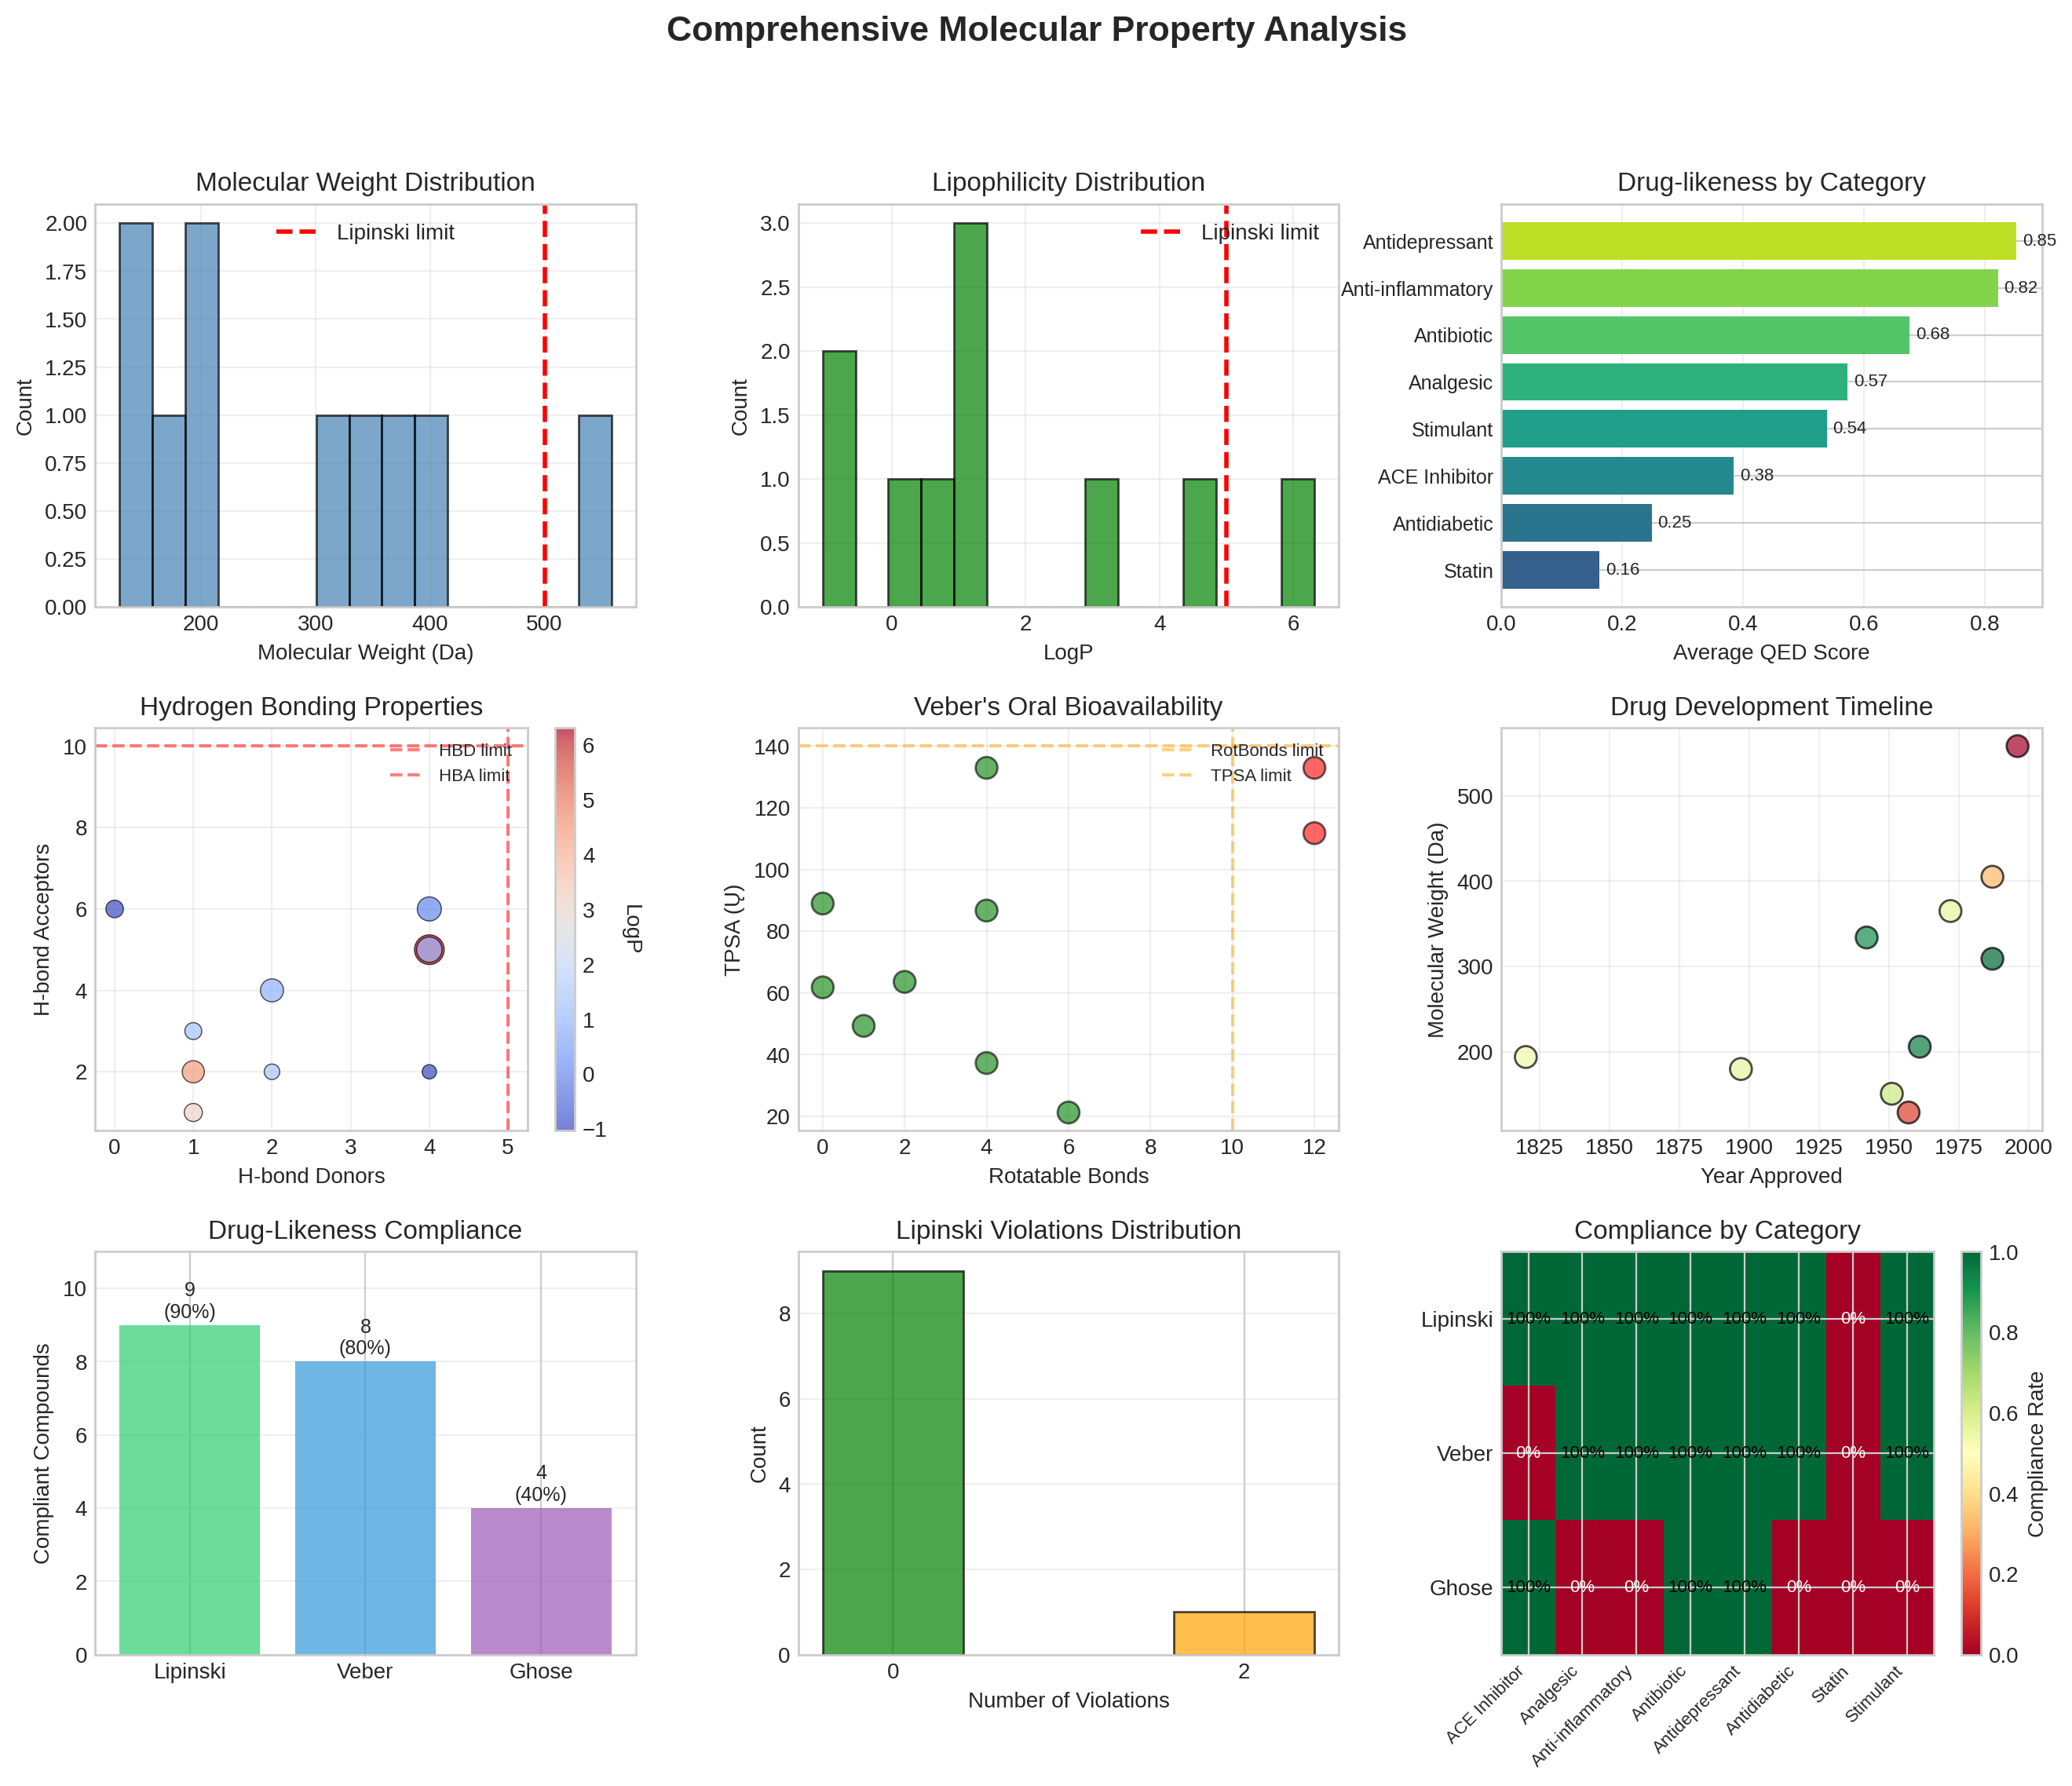

In [8]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Molecular Weight Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df_results['MW'], bins=15, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(500, color='red', linestyle='--', label='Lipinski limit', linewidth=2)
ax1.set_xlabel('Molecular Weight (Da)')
ax1.set_ylabel('Count')
ax1.set_title('Molecular Weight Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. LogP Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df_results['LogP'], bins=15, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(5, color='red', linestyle='--', label='Lipinski limit', linewidth=2)
ax2.set_xlabel('LogP')
ax2.set_ylabel('Count')
ax2.set_title('Lipophilicity Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. QED Score by Category
ax3 = fig.add_subplot(gs[0, 2])
categories = df_results.groupby('Category')['QED'].mean().sort_values()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(categories)))
bars = ax3.barh(range(len(categories)), categories.values, color=colors)
ax3.set_yticks(range(len(categories)))
ax3.set_yticklabels(categories.index, fontsize=9)
ax3.set_xlabel('Average QED Score')
ax3.set_title('Drug-likeness by Category')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, categories.values)):
    ax3.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.2f}', va='center', fontsize=8)

# 4. H-bond Donor vs Acceptor
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(df_results['HBD'], df_results['HBA'], 
                     s=df_results['MW']/3, c=df_results['LogP'],
                     cmap='coolwarm', alpha=0.7, edgecolor='black', linewidth=0.5)
ax4.axvline(5, color='red', linestyle='--', alpha=0.5, label='HBD limit')
ax4.axhline(10, color='red', linestyle='--', alpha=0.5, label='HBA limit')
ax4.set_xlabel('H-bond Donors')
ax4.set_ylabel('H-bond Acceptors')
ax4.set_title('Hydrogen Bonding Properties')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

# Add drug labels
for _, row in df_results.iterrows():
    if row['HBD'] > 4 or row['HBA'] > 8:  # Label outliers
        ax4.annotate(row['Drug'][:4], (row['HBD'], row['HBA']),
                    fontsize=7, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('LogP', rotation=270, labelpad=15)

# 5. TPSA vs Rotatable Bonds (Veber)
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(df_results['RotBonds'], df_results['TPSA'],
           s=100, c=df_results['Veber_Pass'].map({True: 'green', False: 'red'}),
           alpha=0.6, edgecolor='black')
ax5.axvline(10, color='orange', linestyle='--', alpha=0.5, label='RotBonds limit')
ax5.axhline(140, color='orange', linestyle='--', alpha=0.5, label='TPSA limit')
ax5.set_xlabel('Rotatable Bonds')
ax5.set_ylabel('TPSA (Ų)')
ax5.set_title("Veber's Oral Bioavailability")
ax5.legend(loc='upper right', fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Drug Timeline
ax6 = fig.add_subplot(gs[1, 2])
timeline = df_results.sort_values('Year')
ax6.scatter(timeline['Year'], timeline['MW'], 
           s=100, c=timeline['QED'], cmap='RdYlGn',
           alpha=0.7, edgecolor='black')
ax6.set_xlabel('Year Approved')
ax6.set_ylabel('Molecular Weight (Da)')
ax6.set_title('Drug Development Timeline')
ax6.grid(True, alpha=0.3)

# 7. Compliance Summary
ax7 = fig.add_subplot(gs[2, 0])
compliance_data = [
    df_results['Lipinski_Pass'].sum(),
    df_results['Veber_Pass'].sum(),
    df_results['Ghose_Pass'].sum()
]
labels = ['Lipinski', 'Veber', 'Ghose']
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax7.bar(labels, compliance_data, color=colors, alpha=0.7)
ax7.set_ylabel('Compliant Compounds')
ax7.set_title('Drug-Likeness Compliance')
ax7.set_ylim(0, len(df_results) + 1)
ax7.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bar, value in zip(bars, compliance_data):
    percentage = value / len(df_results) * 100
    ax7.text(bar.get_x() + bar.get_width()/2, value + 0.2,
            f'{value}\n({percentage:.0f}%)', ha='center', fontsize=9)

# 8. Lipinski Violations Distribution
ax8 = fig.add_subplot(gs[2, 1])
violations_count = df_results['Lipinski_Violations'].value_counts().sort_index()
colors = ['green' if v <= 1 else 'orange' if v == 2 else 'red' 
          for v in violations_count.index]
ax8.bar(violations_count.index, violations_count.values, 
        color=colors, alpha=0.7, edgecolor='black')
ax8.set_xlabel('Number of Violations')
ax8.set_ylabel('Count')
ax8.set_title('Lipinski Violations Distribution')
ax8.set_xticks(violations_count.index)
ax8.grid(True, alpha=0.3, axis='y')

# 9. Category Performance Matrix
ax9 = fig.add_subplot(gs[2, 2])
category_metrics = df_results.groupby('Category')[['Lipinski_Pass', 'Veber_Pass', 'Ghose_Pass']].mean()
im = ax9.imshow(category_metrics.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax9.set_yticks(range(3))
ax9.set_yticklabels(['Lipinski', 'Veber', 'Ghose'])
ax9.set_xticks(range(len(category_metrics)))
ax9.set_xticklabels(category_metrics.index, rotation=45, ha='right', fontsize=8)
ax9.set_title('Compliance by Category')

# Add text annotations
for i in range(len(category_metrics)):
    for j in range(3):
        value = category_metrics.iloc[i, j]
        text = ax9.text(i, j, f'{value:.0%}',
                       ha="center", va="center",
                       color="white" if value < 0.5 else "black",
                       fontsize=8)

plt.colorbar(im, ax=ax9, label='Compliance Rate')

plt.suptitle('Comprehensive Molecular Property Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 6: Statistical Analysis and Insights

Let's extract meaningful insights from our molecular descriptor analysis.

In [9]:
# Statistical summary
print("STATISTICAL SUMMARY OF MOLECULAR PROPERTIES")
print("="*50)

# Basic statistics
stats_columns = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'QED']
summary_stats = df_results[stats_columns].describe()
print("\nDescriptive Statistics:")
print(summary_stats.round(2))

# Compliance rates
print("\nDRUG-LIKENESS COMPLIANCE RATES:")
print("-"*30)
compliance_metrics = {
    'Lipinski': df_results['Lipinski_Pass'].mean() * 100,
    'Veber': df_results['Veber_Pass'].mean() * 100,
    'Ghose': df_results['Ghose_Pass'].mean() * 100
}

for rule, rate in compliance_metrics.items():
    print(f"{rule:15} {rate:.1f}%")

# Best performing drug
print("\nTOP DRUG-LIKE COMPOUND:")
print("-"*30)
best_drug_idx = df_results['QED'].idxmax()
best_drug = df_results.loc[best_drug_idx]
print(f"Drug: {best_drug['Drug']}")
print(f"Category: {best_drug['Category']}")
print(f"QED Score: {best_drug['QED']:.3f}")
print(f"Lipinski Violations: {best_drug['Lipinski_Violations']}")

# Category analysis
print("\nCATEGORY PERFORMANCE:")
print("-"*30)
category_performance = df_results.groupby('Category')['QED'].agg(['mean', 'std', 'count'])
category_performance = category_performance.sort_values('mean', ascending=False)
print(category_performance.round(3))

# Correlation analysis
print("\nKEY CORRELATIONS:")
print("-"*30)
correlations = df_results[['MW', 'LogP', 'TPSA', 'QED']].corr()['QED'].drop('QED')
for param, corr in correlations.items():
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    direction = "positive" if corr > 0 else "negative"
    print(f"QED vs {param:8} r = {corr:+.3f} ({strength} {direction})")

STATISTICAL SUMMARY OF MOLECULAR PROPERTIES

Descriptive Statistics:
           MW   LogP    HBD    HBA    TPSA    QED
count   10.00  10.00  10.00  10.00   10.00  10.00
mean   283.22   1.65   2.30   3.60   78.67   0.55
std    135.91   2.35   1.57   1.84   38.79   0.23
min    129.10  -1.03   0.00   1.00   21.26   0.16
25%    183.55   0.23   1.00   2.00   52.45   0.42
50%    257.63   1.27   2.00   3.50   75.16   0.55
75%    357.35   2.64   4.00   5.00  106.09   0.75
max    558.25   6.31   4.00   6.00  132.96   0.85

DRUG-LIKENESS COMPLIANCE RATES:
------------------------------
Lipinski        90.0%
Veber           80.0%
Ghose           40.0%

TOP DRUG-LIKE COMPOUND:
------------------------------
Drug: Fluoxetine
Category: Antidepressant
QED Score: 0.852
Lipinski Violations: 0

CATEGORY PERFORMANCE:
------------------------------
                    mean    std  count
Category                              
Antidepressant     0.852    NaN      1
Anti-inflammatory  0.822    NaN      1
Ant

## Part 7: Structure-Property Relationships

Understanding how molecular structure affects properties is crucial for drug design.

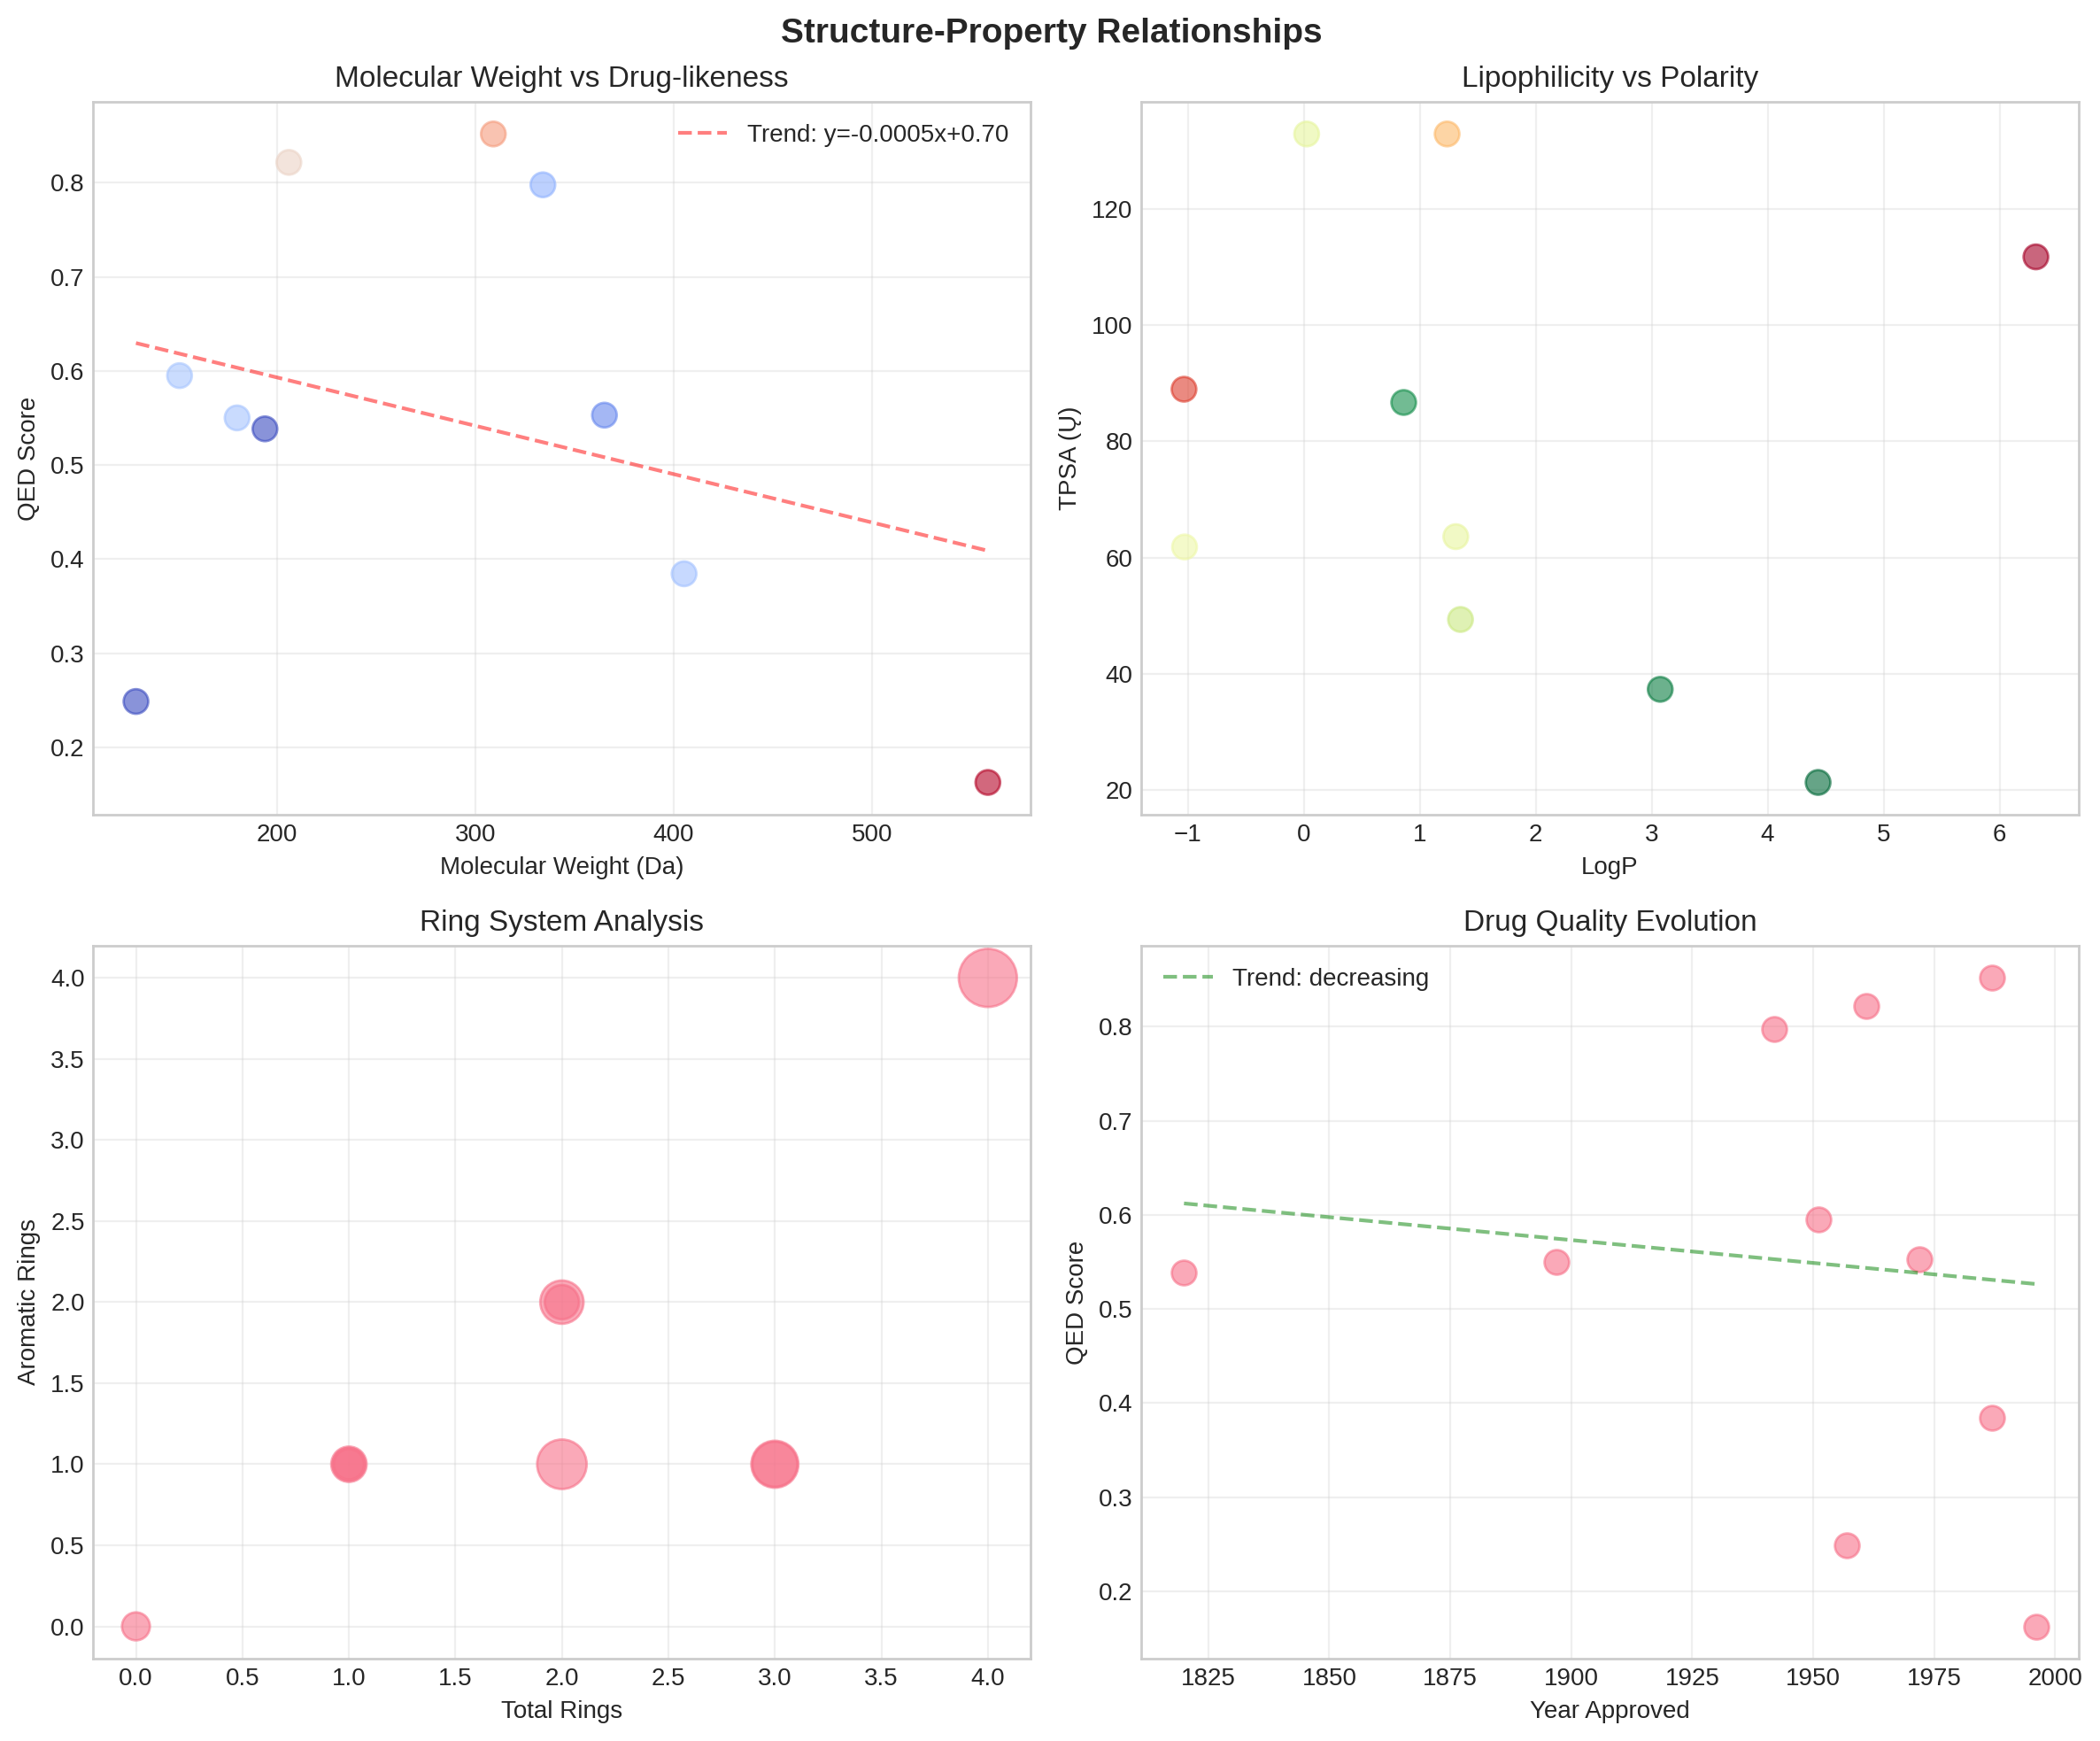

Key Observations:
• MW-QED correlation: -0.298
• LogP-TPSA correlation: -0.183
• Average rings per drug: 1.9
• QED trend over time: Declining


In [10]:
# Analyze structure-property relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MW vs QED
axes[0,0].scatter(df_results['MW'], df_results['QED'], 
                 s=100, alpha=0.6, c=df_results['LogP'], cmap='coolwarm')
axes[0,0].set_xlabel('Molecular Weight (Da)')
axes[0,0].set_ylabel('QED Score')
axes[0,0].set_title('Molecular Weight vs Drug-likeness')
axes[0,0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_results['MW'], df_results['QED'], 1)
p = np.poly1d(z)
axes[0,0].plot(df_results['MW'].sort_values(), 
              p(df_results['MW'].sort_values()),
              "r--", alpha=0.5, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
axes[0,0].legend()

# LogP vs TPSA
axes[0,1].scatter(df_results['LogP'], df_results['TPSA'],
                 s=100, alpha=0.6, c=df_results['QED'], cmap='RdYlGn')
axes[0,1].set_xlabel('LogP')
axes[0,1].set_ylabel('TPSA (Ų)')
axes[0,1].set_title('Lipophilicity vs Polarity')
axes[0,1].grid(True, alpha=0.3)

# Rings vs Complexity
axes[1,0].scatter(df_results['Rings'], df_results['AromaticRings'],
                 s=df_results['MW'], alpha=0.6)
axes[1,0].set_xlabel('Total Rings')
axes[1,0].set_ylabel('Aromatic Rings')
axes[1,0].set_title('Ring System Analysis')
axes[1,0].grid(True, alpha=0.3)

# Year vs QED (drug evolution)
axes[1,1].scatter(df_results['Year'], df_results['QED'],
                 s=100, alpha=0.6)
axes[1,1].set_xlabel('Year Approved')
axes[1,1].set_ylabel('QED Score')
axes[1,1].set_title('Drug Quality Evolution')
axes[1,1].grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(df_results['Year'], df_results['QED'], 1)
p2 = np.poly1d(z2)
axes[1,1].plot(df_results['Year'].sort_values(),
              p2(df_results['Year'].sort_values()),
              "g--", alpha=0.5, label=f'Trend: {"increasing" if z2[0] > 0 else "decreasing"}')
axes[1,1].legend()

plt.suptitle('Structure-Property Relationships', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"• MW-QED correlation: {df_results['MW'].corr(df_results['QED']):.3f}")
print(f"• LogP-TPSA correlation: {df_results['LogP'].corr(df_results['TPSA']):.3f}")
print(f"• Average rings per drug: {df_results['Rings'].mean():.1f}")
print(f"• QED trend over time: {'Improving' if z2[0] > 0 else 'Declining'}")

## Summary and Applications

### What You've Learned

**Technical Skills:**
-  Molecular descriptor calculation using RDKit
-  Drug-likeness assessment (Lipinski, Veber, Ghose)
-  ADMET property prediction
-  Structure-property relationship analysis
-  Professional data visualization for drug discovery

**Scientific Concepts:**
-  QSAR principles
-  Oral bioavailability factors
-  Molecular complexity metrics
-  Drug development evolution

### Real-World Applications

1. **Virtual Screening**: Filter millions of compounds before synthesis
2. **Lead Optimization**: Improve drug candidates systematically
3. **ADMET Prediction**: Reduce late-stage failures
4. **Patent Analysis**: Assess competitor compounds
5. **Personalized Medicine**: Tailor drugs to patient genetics

### Industry Impact

- **Cost Reduction**: Save millions in synthesis and testing
- **Time Savings**: Reduce drug development from 15 to 10 years
- **Success Rate**: Increase clinical trial success from 10% to 15%
- **Innovation**: Enable exploration of novel chemical space

### Next Steps

1. **Machine Learning**: Build QSAR models for activity prediction
2. **Molecular Docking**: Study drug-protein interactions
3. **Pharmacophore Modeling**: Identify essential features
4. **Toxicity Prediction**: Assess safety profiles
5. **Fragment-Based Design**: Create novel molecules

### Resources for Continued Learning

**Software Tools:**
- RDKit: Open-source cheminformatics
- ChEMBL: Bioactivity database
- PubChem: Chemical information
- SwissADME: ADMET prediction

**Literature:**
- Lipinski et al. (2001) "Experimental and computational approaches"
- Veber et al. (2002) "Molecular properties that influence oral bioavailability"
- Bickerton et al. (2012) "Quantifying the chemical beauty of drugs"

### Career Opportunities

**Computational Chemistry Roles:**
- Cheminformatics Scientist: $90,000 - $150,000/year
- Drug Discovery Scientist: $100,000 - $180,000/year
- QSAR Modeler: $85,000 - $140,000/year
- Medicinal Chemist: $95,000 - $160,000/year

The pharmaceutical industry increasingly relies on computational methods. Your skills in molecular descriptor analysis position you at the forefront of modern drug discovery!